In [1]:
import json
import numpy as np
import pandas as pd
import os

from IPython.display import display, Math
from scipy import optimize, stats
from math import exp, cos, sqrt, pi, sin, sqrt, e

from src.OspitalettoDataset import OspitalettoDataset
from src.NOAA2010Dataset import NOAA2010Dataset
from src.InsPireDataset import InsPireDataset

## Constants to be used across the notebook

In [4]:
simulation_values_path = os.path.join(".", "data", "simulation_values.json")    
with open(simulation_values_path, "r") as f:
    simulation_values = json.load(f)
    
simulation_values

{'Heat_demand': 75891,
 'Heat_year': 75891,
 'Cool_demand': 34381,
 'Cool_year': 34381,
 'Interest_Rate': 0.03,
 'T_base_cool_degree': 17,
 'T_base_heat_degree': 15,
 'Tdhw': 38.0,
 'Tmax_i': 38.0,
 'Tmin_i': 30.0,
 'DT_evap': 10.0,
 'Ts1': 25.0,
 'Ts2': 25.0,
 'cap_ground': 5,
 'cap_source1': 7.648,
 'cap_source2': 0,
 'depth_aquifer': 30.0,
 'n_buildings_MFH': 1600.0,
 'n_buildings_SFH': 0.0,
 's1_schedule': [[1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 

In [50]:
load_or_write_new = int(input("Press 1 if you want to reload previous simulation values"))

if load_or_write_new == 1:    
    Tmin_i = simulation_values["Tmin_i"]
    Tmax_i = simulation_values["Tmax_i"]

    Tdhw = simulation_values["Tdhw"]

    Ts1 = simulation_values["Ts1"]
    Ts2 = simulation_values["Ts2"]

    DT_evap = simulation_values["DT_evap"]
    
    n_buildings_SFH = simulation_values["n_buildings_SFH"]
    n_buildings_MFH = simulation_values["n_buildings_MFH"]
    
    cap_source1= simulation_values['cap_source1']
    cap_source2= simulation_values['cap_source2']
    cap_ground= simulation_values['cap_ground']

    depth_aquifer = simulation_values["depth_aquifer"]
    
    T_base_heat_degree = simulation_values["T_base_heat_degree"]
    
    T_base_cool_degree = simulation_values["T_base_cool_degree"]
    
    CD_year=simulation_values["Cool_year"]
    HD_year=simulation_values["Heat_year"]
    
    Interest_Rate=simulation_values["Interest_Rate"]
    
else:
    # Min and Max temperatures to be received by the user.
    # Values [40,...,60]
    Tmin_i = float(input("Enter min setpoint temperature: "))
    Tmax_i = float(input("Enter max setpoint temperature: "))

    # Domestic hot water temperature.
    # Values [45,...,55]
    Tdhw = float(input("Enter domestic hot water temperature: "))

    # Our model supposes that the system has two different sources of heat.
    # Values [20,...,30]
    Ts1 = float(input("Temperature of source 1: "))
    Ts2 = float(input("Temperature of source 2: "))

    # difference in temperature between the supply (system->heat->house) and return (house -> heat -> system) pipes
    # Values [1,...,10]
    DT_evap = float(input("Temperature difference among the supply and return pipes: "))
    
    # For the data visualization course, we will select 0 SFH & 1600 MFH buildings, which will cover an area of 1 km2
    n_buildings_SFH =float(input("Enter the number of SFH buildings: #"))
    n_buildings_MFH = float(input("Enter the number of MFH buildings:#"))
    
    cap_source1 = int(input("Enter the thermal capacity of source 1 in MW:"))
    cap_source2 = int(input("Enter the thermal capacity of source 2 in MW:"))
    cap_ground = int(input("Enter the thermal capacity of the ground in MW:"))

    # The depth of the aquifer in meters. Values are around 30.
    depth_aquifer = float(input("Aquifer temperature depth: "))
    
    T_base_heat_degree = int(input("Heat Degree Days base temperature: "))
    
    T_base_cool_degree = int(input("Cool Degree Days base temperature: "))
    
    CD_year=int(input("Cooling demand/year: ")) #Of the scenario
    HD_year=int(input("Cooling demand/year: ")) #Of the scenario
    
    Interest_Rate=int(input("Insert the interest rate of the project: ")) #Of the scenario
    
print(f"* {Tmin_i=}\n"
      f"* {Tmax_i=}\n"
      f"* {CD_year=}\n"
      f"* {HD_year=}\n"
      f"* {Tdhw=}\n"
      f"* {Ts1=}\n"
      f"* {Ts2=}\n"
      f"* {DT_evap=}\n"
      f"* {n_buildings_SFH=}\n"
      f"* {n_buildings_MFH=}\n"
      f"* {cap_source1=}\n"
      f"* {cap_source2=}\n"
      f"* {cap_ground=}\n"
      f"* {depth_aquifer=}\n"
      f"* {T_base_heat_degree=}\n"
      f"* {T_base_cool_degree=}\n"
      f"* {Interest_Rate=}\n"
     )

Press 1 if you want to reload previous simulation values 1


* Tmin_i=30.0
* Tmax_i=38.0
* CD_year=34381
* HD_year=75891
* Tdhw=38.0
* Ts1=25.0
* Ts2=25.0
* DT_evap=10.0
* n_buildings_SFH=0.0
* n_buildings_MFH=1600.0
* cap_source1=7.648
* cap_source2=0
* cap_ground=5
* depth_aquifer=30.0
* T_base_heat_degree=15
* T_base_cool_degree=17
* Interest_Rate=0.1



# Load Sources working hours

The file must be a boolean matrix $W$ of $24 x 7$. The rows represent the hours in a day, and the columns represent the days in the week. For all $i \in \{0,...,23\}$ and $j \in \{0,..., 6\}$ we have that $w_{i,j} \in \{0, 1\}$, where $w_{i,j} = 0$ means that the source doesn't produce energy at that hour $i$ on that day $j$. Similarly, $w_{i,j} = 1$ means that the source produces energy at that hour $i$ on that day $j$.

In [5]:
s1_schedule_path = os.path.join(".", "data", "private", "s1_source_fake_schedule.xlsx")
if load_or_write_new == 1:
    s1_schedule = np.array(simulation_values["s1_schedule"])
else:    
    s1_schedule = pd.read_excel(s1_schedule_path, index_col="Time").to_numpy()

print(f"* {s1_schedule_path=}\n"
      f"* {s1_schedule=}\n"
      f"* {s1_schedule[6,1]=}\n" # Tuesdays are closed at 6 (equal to 0)
      f"* {s1_schedule[7,1]=}\n") # but open are 7 (equal to 1)

* s1_schedule_path='./data/private/s1_source_fake_schedule.xlsx'
* s1_schedule=array([[1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1]])
* s1_schedule[6,1]=1
* s1_schedule[7,1]=1



In [6]:
s2_schedule_path = os.path.join(".", "data", "private", "s2_source_fake_schedule.xlsx")
if load_or_write_new == 1:
    s2_schedule = np.array(simulation_values["s2_schedule"])
else: 
    s2_schedule = pd.read_excel(s2_schedule_path, index_col="Time").to_numpy()

print(f"* {s2_schedule_path=}\n"
      f"* {s2_schedule=}\n"
      f"* {s2_schedule[15,1]=}\n" # Tuesdays are closed at 15 (equal to 0)
      f"* {s2_schedule[16,1]=}\n") # but open are 16 (equal to 1)

* s2_schedule_path='./data/private/s2_source_fake_schedule.xlsx'
* s2_schedule=array([[1, 1, 0, 0, 1, 1, 0],
       [1, 1, 0, 0, 1, 1, 0],
       [1, 1, 0, 0, 1, 1, 0],
       [1, 1, 0, 0, 1, 1, 0],
       [1, 1, 0, 0, 1, 1, 0],
       [1, 1, 0, 0, 1, 1, 0],
       [1, 1, 0, 0, 1, 1, 0],
       [1, 1, 0, 1, 1, 1, 0],
       [1, 1, 0, 1, 1, 1, 0],
       [1, 1, 0, 1, 1, 1, 0],
       [1, 1, 0, 1, 1, 1, 0],
       [1, 1, 0, 1, 1, 1, 0],
       [1, 1, 0, 1, 1, 1, 0],
       [1, 1, 0, 1, 1, 1, 0],
       [1, 1, 0, 1, 1, 1, 0],
       [1, 1, 0, 1, 1, 1, 0],
       [1, 0, 0, 1, 1, 1, 0],
       [1, 0, 0, 1, 1, 0, 0],
       [1, 0, 0, 1, 1, 0, 0],
       [1, 0, 0, 1, 1, 0, 0],
       [1, 0, 0, 1, 1, 0, 0],
       [1, 0, 0, 1, 1, 0, 0],
       [1, 0, 0, 1, 1, 0, 0],
       [1, 0, 0, 1, 1, 0, 0]])
* s2_schedule[15,1]=1
* s2_schedule[16,1]=0



## Take note of the values for the current simulation

In [7]:
simulation_values["Tmin_i"] = Tmin_i
simulation_values["Tmax_i"] = Tmax_i
simulation_values["Tdhw"] = Tdhw
simulation_values["Ts1"] = Ts1
simulation_values["Ts2"] = Ts2
simulation_values["DT_evap"] = DT_evap
simulation_values["s1_schedule"] = s1_schedule.tolist()
simulation_values["s2_schedule"] = s2_schedule.tolist()
simulation_values["n_buildings_SFH"] = n_buildings_SFH
simulation_values["n_buildings_MFH"] = n_buildings_MFH
simulation_values['cap_source1']  = cap_source1
simulation_values['cap_source2'] =  cap_source2
simulation_values['cap_ground'] =  cap_ground
simulation_values["depth_aquifer"] = depth_aquifer
simulation_values["T_base_heat_degree"] = T_base_heat_degree
simulation_values["T_base_cool_degree"] = T_base_cool_degree
simulation_values["Cool_demand"] =CD_year
simulation_values["Heat_demand"] =HD_year

#simulation_values

## Read the dataset

In [8]:
noaa2010Dataset = NOAA2010Dataset()
insPireDataset = InsPireDataset()


AVAILABLE_DATASETS = dict()
#AVAILABLE_DATASETS.update(noaa2010Dataset.load_data())
AVAILABLE_DATASETS.update(insPireDataset.load_data())

AVAILABLE_DATASETS.keys()

dict_keys(['london_uk', 'madrid_spain', 'rome_italy', 'stuttgart_germany'])

In [9]:
dataset_to_work = "rome_italy"
dataset_to_work

'rome_italy'

In [10]:
dataset = AVAILABLE_DATASETS[dataset_to_work]
dataset.columns

Index(['hourofyear', 'air_temp', 'city_key', 'climate', 'DHW_cons', 'SH_cons',
       'SFH_bldg_tot', 'MFH_bldg_tot', '%SH_y', '%DHW_y', 'Gas_price_ind',
       'Gas_price_res', 'El_price_ind', 'El_price_res', 'WH_price', 'CO2_gas',
       'DHW_hourly_consumption_ratio', 'SH_hourly_consumption_ratio',
       'SC_hourly_consumption_ratio', 'Carbon_emissions_profile', 'season',
       'date', 'month', 'dayofyear', 'dayofweek', 'hour'],
      dtype='object')

## Definition of the dataset-related constants

- `T_daily_a`: Average air temperature on a daily basis. 
- `DT_y`: Difference between the maximum daily temperature and the mean daily temperature.
- `d_shift_min`: Day of the year with the min read temperature.
- `d_shift_max`: Day of the year with the max read temperature.

In [11]:
# Create a daily dataset
T_daily_avg = dataset["air_temp"].resample('D').mean().to_frame()
T_daily_avg["dayofyear"] = T_daily_avg.index.dayofyear
T_daily_avg["month"] = T_daily_avg.index.month
T_daily_avg["hourofyear"] = (T_daily_avg.index.dayofyear - 1) * 24 + (T_daily_avg.index.hour + 1)

T_ave_h = T_daily_avg.air_temp.mean()
T_max = T_daily_avg.air_temp.max()
DT_y = T_max - T_ave_h

d_shift_min = T_daily_avg.air_temp.idxmin(axis=0).dayofyear #Day of the min Temperature
d_shift_max = T_daily_avg.air_temp.idxmax(axis=0).dayofyear #Day of the max Temperature

t = T_daily_avg.dayofyear

num_hours = dataset.shape[0] # Number of hours in a year = 8737 hrs
h = dataset.hourofyear # A range equivalent to the hours of the year from 1 to 8761

#print(f"* {dataset=}\n"
 #     f"* {T_daily_avg=}\n"
  #    f"* {T_ave_h=}\n"
   #   f"* {DT_y=}\n"
    #  f"* {d_shift_min=}\n"
    #  f"* {T_daily_avg.air_temp.min()=}\n"
    #  f"* {d_shift_max=}\n"
    #  f"* {T_daily_avg.air_temp.max()=}\n"
    #  f"* {t=}\n"
    #  f"* {num_hours=}\n"
    #  f"* {h=}")

## Functional unit composition

A functional unit of 1 km2 of land with a pre-determined heat demand and cooling demand is selected for analysis. This reference area has been already investigated in previous publications for the scenario assessment of low-temperature DH networks, as a typical high-density urban zone.


### District heating system diagram

District heating (DH) is an energy service based on moving heat from available heat sources to immediate customers through a piping network. Nowadays, the fundamental idea of DH is to use LOCAL sources that would otherwise be WASTED in order to satisfy customers'needs (Werner, 2013). 


Traditional DH systems operate typically at temperatures far from the ambient temperature (80°C or higher) giving rise to high thermal losses and the need of costly piping insulation. Examples of traditional DH sources are cogeneration plants, industrial waste heat and incinerators, where heat is a by-product of other industrial processes (Cozzini, 2018).

New concepts in the DH sector propose lowering the operating temperatures further to a level equivalent to the ambient temperature, with an average of 20°C. Advantages of a system of this kind, are the reduction in thermal losses in the distribution system, the direct exploitation of available waste heat sources (refrigeration units in shopping malls, supermarkets, datacenters) and ground sources (aquifer wells), and the possibility of providing not only heating but also cooling through the use of reversible heat pumps on the buildings substations, as presented in the Figure.

![DHC system](images/DHC_system.png)

## 1. Data Processing for Space Heating Demand and Domestic Hot Water

The methodology used in this project is a bottom-up approach for the calculation of the total heat demand for space heating (SH) and domestic hot water (DHW) utilization of a district located in 4 different climates across Europe, using data from the Inspire project. The data includes annual energy consumption for each building typology in kWh/m2-y, SFHs and MFHs correspond to reference buildings in each climatic zone built between 1945-1970, non-refurbished. In this particular case, the climatic zones and reference cities considered are:

* Stuttgart, Germany for Continental climate
* London, United Kingdom for Oceanic climate
* Madrid, Spain for Southern-dry climate
* Rome, Italy for Mediterranean climate

\begin{align*}
HD = {SH}  + {DHW}
\end{align*}

It's important to stress that this calculation is done on a year basis.

## 1.0 Data processing for space heating (SH) and domestic hot water (DHW)

The total heat demand in a year is determined by the user of the model. This value corresponds to the demand of the city quarter selected to provide heat which constitutes the scenario.

In [12]:
#dataset["Heat_demand"] = (n_buildings_SFH * 100 * dataset["SFH_bldg_tot"]) + (n_buildings_MFH * 500 * dataset["MFH_bldg_tot"])
dataset["Heat_demand"] = HD_year
dataset["SH_demand"] = HD_year * dataset["%SH_y"]
dataset["DHW_demand"] = dataset["Heat_demand"] * dataset["%DHW_y"] # Equivalently, we can change dataset["%DHW_y"] with (1 - dataset["%SH_y"])

## 1.1 Space Heating demand (H)

In order to analyse the performance of this particular DH system, it is fundamental not only the spatial distribution of the heat demand, but also the distribution over time. For this purpose, the space heating hourly profile for each location is retrieved with a time dependency according to the heating degree method, known as the "Integration method".

This method accounts the amount (in degrees) and for how long (in hours) thermal heat is required to keep the indoor building temperature at a comfortable level, which will vary depending on different climates according to the average daily outdoor temperature ($T_{amb}$). The base temperature $T_{base}$ selected was set to 15 °C, however, this value can be modified by the user of the tool. The calulation is performed on a daily basis:


\begin{equation}
HDD_{i}= T_{base}-T_{amb,i} 
\end{equation}


$T_{amb,i} $= Average outdoor temperature in day $i$ ($i=1,...,365$).

Thus, the heating distribution along the year can be estimated as:

\begin{equation}
E_{th,j}= E_{th,sh}\times \frac{HDD_{i}}{\sum_{i=1}^{365} HDD_{i}} \times p{j}
\end{equation}

Where $E_{th,sh}$ is the annual thermal energy for space heating, $HDD_{i}$ are the heating degrees in a day ${i}$, and $p_{j}$ is a user-determined hourly profile (${i=1,...,24}$)
More info on calculation method: https://www.degreedays.net/introduction

In [13]:
def heating_degree(T_amb):
    return max(0, T_base_heat_degree - T_amb)

In [14]:
def cooling_degree(T_amb):
    return max(0, T_amb-T_base_cool_degree)

In [15]:
heating_degree_days = T_daily_avg.air_temp.apply(heating_degree)
cooling_degree_days = T_daily_avg.air_temp.apply(cooling_degree)
#dataset["space_heating_dist"] = dataset.heating_degree_days / max(sum(dataset.heating_degree_days), 1)
#dataset["SH_dist"] = dataset["SH_demand"] * dataset["space_heating_dist"] 
#Space heating distribution according to heating degree hours+SH profile

T_daily_avg["heat_degree_days"]= heating_degree_days/ sum(heating_degree_days)
T_daily_avg["cooling_degree_days"]= cooling_degree_days/ sum(cooling_degree_days)
T_daily_avg = T_daily_avg.resample('H').ffill()


## 1.2 Space heating profile distribution

Text(0, 0.5, 'Thermal SH demand[MW]')

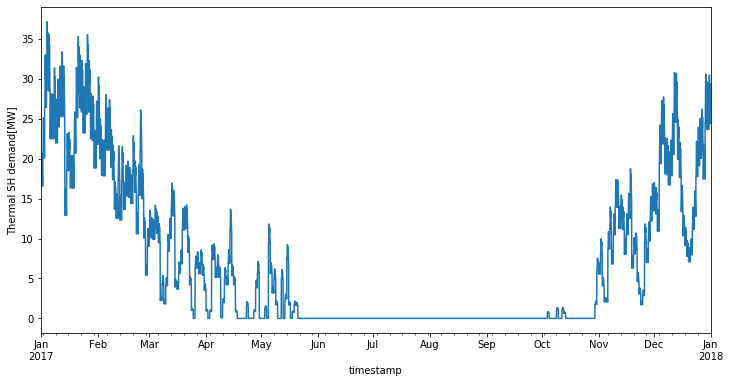

In [16]:
#dataset["heating_degree_days"] = dataset.air_temp.apply(heating_degree)
#dataset["space_heating_dist"] = dataset.heating_degree_days / max(sum(dataset.heating_degree_days), 1) 

dataset["norm_SH_profile"] = dataset.SH_hourly_consumption_ratio

#Space heating profile according to degree days 

dataset["SH_dist"] = dataset.SH_demand  * dataset.norm_SH_profile * T_daily_avg.heat_degree_days 
#Space heating distribution according to heating degree hours+SH profile

ax=dataset.SH_dist.plot(figsize=(12,6))
ax.set_ylabel('Thermal SH demand[MW]')


## 1.2 Domestic Hot Water Consumption (H)

Domestic hot water consumption is not weather influenced, and its variation is almost constant over the year. The hourly demand for hot water is estimated by the percentage of the total heat demand ($ HD_y $) is hot water $ DHW_y $. This data is also obtained from the INSPIRE database for different climatic zones. 

The total domestic hot water demand is evenly distributed over each day of the year, and then its hourly distribution is obtained by multiplying the daily needs by an hourly random profile. 

\begin{align*}
DHW_{d} = \frac{HD_{y}*DHW_{\%y}}{d}
\end{align*}

The DHW consumption is calculated in an hourly fashion.

In [17]:
dataset["DHW_dist"] = dataset["DHW_demand"] * dataset["DHW_hourly_consumption_ratio"] / 365
dataset.SH_dist.sum(), dataset.DHW_dist.sum()

(61502.877101494254, 13660.525906822193)

## 1.3 Alternative thermal load profile

An user-defined thermal profile can be provided through load values of a typical day per month in MW (24-hour profile replicated by the number of days in a month, 12 months in a year).

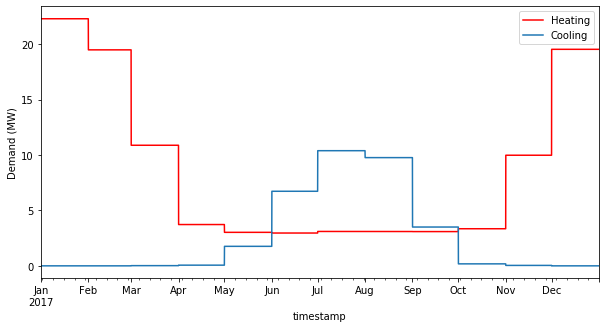

In [43]:
thermal_load_data = pd.read_excel("./data/insPire/thermal_demand_monthly.xlsx", delimiter =';') 
thermal_load_data['timestamp'] = pd.date_range(start='1/1/2017', freq="MS", periods=12)
thermal_load_data = thermal_load_data.set_index("timestamp")

thermal_load_data = thermal_load_data.resample("H").ffill()

df3 = thermal_load_data.iloc[[-1]].rename(lambda x: x + pd.offsets.YearBegin())

thermal_load_data=thermal_load_data.append(df3).resample('h').ffill().iloc[:-1]


ax = thermal_load_data.heating_profile.plot(figsize=(10,5), color ='red')
ax.set_ylabel("Thermal load (MW)")


axx = thermal_load_data.cooling_profile.plot(figsize=(10,5))
axx.set_ylabel("Demand (MW)")
ax.legend(["Heating", "Cooling"], loc='upper right');

## 1.3 Space cooling 

In [ ]:
dataset["Cool_demand"] = CD_year
#dataset["cooling_degree_days"] = T_daily_avg.air_temp.apply(cooling_degree)
#dataset["space_cooling_dist"] = dataset.cooling_degree_days / sum(dataset.cooling_degree_days)

dataset["norm_SC_profile"] = dataset.SC_hourly_consumption_ratio
dataset["SC_consumption"] = dataset.Cool_demand *  dataset.norm_SC_profile *T_daily_avg.cooling_degree_days #Applying a smoothing factor
                                                                                  #that considers users'behavior. **In this case assumed equal to the DHW profile**
ax=dataset['2017-06-24':'2017-07-26']["SC_consumption"].plot(figsize=(12,6))
ax.set_ylabel("MW")

## 1.4 Thermal Load Profile (H) 

Thus, the aggregated heat demand corresponds to the sum of the thermal heat requirements for SH and DHW, according to the equation:

\begin{align*}
HD_{TOT, h} = HD_{SH, h} + HD_{DHW, h}
\end{align*}

In [ ]:
dataset["Thermal_consumption"] = dataset["DHW_dist"] + dataset["SH_dist"]

ax=dataset['Thermal_consumption'].plot(figsize=(12,6))
ax.set_ylabel("MW")

### 3.4.1 Adjusting the total consumption by air temperature

In [ ]:
dataset["Total_consumption_fit"] = np.nan

records_with_heat_degree_days = dataset[dataset.air_temp <= T_base_heat_degree]
if records_with_heat_degree_days.shape[0] == 0:
    print(f"Key {dataset_to_work} has no degree days.")
else:
    slope, intercept, r_value, p_value, std_err = stats.linregress(records_with_heat_degree_days.air_temp, records_with_heat_degree_days.Thermal_consumption)
    dataset["Total_consumption_fit"] = slope * records_with_heat_degree_days.air_temp + intercept


In [47]:
# Updating heating and cooling data when available

dataset["Thermal_consumption"] = thermal_load_data.heating_profile

dataset["SC_consumption"] = thermal_load_data.cooling_profile


## 2.0 Temperature levels required on the buildings: Climate Curve (H)

Temperature levels required for SH and DHW. The space Heating is calculated using a climatic curve. The Hot Water temperature is constant across the year.

In [ ]:
def climatic_curve(Tamb_h):
    Tmin_o = 2.38 #minimum outdoor T threshold in which the space heating system turns on
    Tmax_o = 7.25 #maximum outdoor T threshold in which the space heating system turns off

    if Tamb_h <= Tmin_o:   
        Tsh = Tmax_i
    elif Tamb_h >= Tmax_o:
        Tsh = Tmin_i
    else:
        m = (Tmax_i-Tmin_i)/(Tmin_o-Tmax_o)
        b = -m*Tmin_o+Tmax_i
        Tsh = m*Tamb_h+b
    return Tsh

In [ ]:
dataset['space_heating_temp'] = dataset.air_temp.apply(climatic_curve)
dataset["hot_water_temp"] = Tdhw

## 2.1 Average Users Temperature Level (H)

This corresponds to the average temperature level that the buildings require from the network. The temperature is based on the indoor temperature setpoints which vary seasonally.

In [ ]:
sh_consumption_ratio = dataset["SH_dist"] / dataset["Thermal_consumption"]
dhw_consumption_ratio = dataset["DHW_dist"] / dataset["Thermal_consumption"]

dataset["user_temp"] = (sh_consumption_ratio * dataset.space_heating_temp 
                        + dhw_consumption_ratio * dataset.hot_water_temp)


## 3. Ambient temperature and Fitting Curve (H)

For more info visit the [scipy.optimize.curve_fit docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html#scipy.optimize.curve_fit)

In [ ]:
def func(x, disp, amp, phi):
    t0 = len(h) # hourly resolution if x is in hours
    omega = 2 * pi / t0
    return disp + amp * np.cos(x * omega - phi)

x_data = pd.Series(range(0,len(dataset)))
y_data = dataset.air_temp
params, params_covariance = optimize.curve_fit(func, x_data, y_data, p0=[T_ave_h, DT_y, d_shift_max * 24])
print(f"* {params=}\n"
      f"* {params_covariance=}")

In [ ]:
T_ave_fit = params[0]
DT_y_fit = params[1]
phi = params[2] #Corresponds to day 202

#'displacement, amplitude, and phase of the signal
print('Fitted parameters:')
display(Math(f"dist={T_ave_fit:.2f}, amp={DT_y_fit:.2f}, \\phi={phi:.2f}"))

print('Original parameters:')
display(Math(f"dist={T_ave_h:.2f}, amp={DT_y:.2f}, \\phi={d_shift_max*24:.2f}"))

## 3.1 Calculate the fitting curve

Using the fitted parameters we can calculate the fitted air temperature

In [ ]:
def fitting_curve(hourofyear, T_ave_fit, DT_y_fit, T, phi, pi):
    omega = 2 * pi / T
    return T_ave_fit + DT_y_fit * np.cos(hourofyear * omega - phi)

In [ ]:
T = dataset.hourofyear.shape[0]
dataset["air_temp_fit"] = dataset.hourofyear.apply(fitting_curve, args=(T_ave_fit, DT_y_fit, T, phi, pi))

d_shift_min = dataset.air_temp_fit.idxmin(axis=0)
d_shift_max = dataset.air_temp_fit.idxmax(axis=0)

dd_min = dataset[dataset.index == d_shift_min].dayofyear.item() # d_shift_min / 24
dd_max = dataset[dataset.index == d_shift_max].dayofyear.item() # d_shift_max / 24

print(f'* {T=}\n'
      f'* {dataset[["air_temp_fit"]]=}\n'
      f'* d_min (h): {d_shift_min}\n'
      f'* day_number: {dd_min}\n'
      f'* d_max (h): {d_shift_max}\n'
      f'* day_number: {dd_max}')

## 3.2 Ground temperature

The ground temperature is calculated as a function of the ambient temperature fitting curve using the Kusuda equation, ref: 
- [Measurements of Ground Temperature at Various Depths](https://www.researchgate.net/publication/30500372_Measurements_of_Ground_Temperature_at_Various_Depths?enrichId=rgreq-e2031a024b742c0018bb428dca3100f5-XXX&enrichSource=Y292ZXJQYWdlOzMwNTAwMzcyO0FTOjEwMTI0NTIzNDcxMjU4M0AxNDAxMTUwMTUzNjYy&el=1_x_2&_esc=publicationCoverPdf)
- [Earth Temperatures and Thermal Diffusivity at Selected Stations in the United States](https://nvlpubs.nist.gov/nistpubs/Legacy/RPT/nbsreport8972.pdf)

In [ ]:
zz = 1 # Depth [m]
alpha = 0.06048 # Ground thermal diffusivity, Banks [m^2/day]
alpha_sec = 7e-7 # Ground thermal diffusivity, Banks [m^2/s]
t_sec = 365 * 24 * 3600 # Number of seconds in a year.

t_0 = T_daily_avg.shape[0] # Number of days in a year =365 days

Tg_und = T_ave_fit # Undisturbed ground temperature
DT_y = abs(DT_y_fit)

print(f"* {zz=}\n"
      f"* {alpha=}\n"
      f"* {alpha_sec=}\n"
      f"* {t_sec=}\n"
      f"* {t_0=}\n"
      f"* {Tg_und=}\n"
      f"* {DT_y=}\n"
      f"* {dd_min=}\n"
      f"* {dd_max=}")

In [ ]:
def ground_temperature_hour(t: int):
    #t is time in hours, but the calculation is done is seconds
    kusuda = Tg_und - DT_y*exp(-zz*sqrt(pi/(alpha_sec*t_sec))) *cos(2*pi/t_sec*((t-dd_min*24)*3600-zz/2*sqrt(t_sec/(pi*alpha_sec)))) #Kusuda
    return pd.Series({'T_kusuda': kusuda})

In [ ]:
dataset["ground_temp"] = dataset.hourofyear.apply(ground_temperature_hour)


## 3.3 Aquifer Well Temperature (Y)

We use the same equation (Kusuda) to calculate the temperature of an aquifer well located `depth_aquifer` meters depth.

In [ ]:
zz = depth_aquifer

print(f"* {zz=}\n"
      f"* {alpha=}\n"
      f"* {alpha_sec=}\n"
      f"* {t_sec=}\n"
      f"* {t_0=}\n"
      f"* {Tg_und=}\n"
      f"* {DT_y=}\n"
      f"* {dd_min=}\n"
      f"* {dd_max=}")

In [ ]:
dataset["aquifer_temp"] = dataset.hourofyear.apply(ground_temperature_hour)

## 4. Network temperature (H)

### 4.1 Calculate Sources Temperature based on Working Hours

In [ ]:
dayofweeks = dataset.index.dayofweek
hours = dataset.index.hour

In [ ]:
dataset["source1_temp"] = Ts1 * s1_schedule[hours, dayofweeks]
dataset["source2_temp"] = Ts2 * s2_schedule[hours, dayofweeks]


### 4.2 Calculate Network Temperature according to sources availability

In [ ]:
def calculate_tnet(temp_s1, temp_s2, temp_aq):
    if temp_s1 == 0.0 and temp_s2 == 0.0:
        return temp_aq
    elif temp_s1 == 0.0:
        return temp_s2
    elif temp_s2 == 0.0:
        return temp_s1
    else:
        return np.min([temp_s1, temp_s2])

In [ ]:
dataset["net_temp"] = dataset.apply(lambda fila: calculate_tnet(fila.source1_temp, fila.source2_temp, fila.aquifer_temp), axis=1)

In [ ]:
ax=dataset.net_temp.plot(figsize=(20,6), title='Network temperature')
ax.set_ylabel("°C")

## 5. System performance
### 5.1 Coefficient of performance (COP)

Heat pumps located at the users' substations are responsible for lifting the network temperature to a desired level for SH and DHW consumptions. The performance of the overall system in heating mode is assessed according to the following coefficient of performance (COP) function:

\begin{equation}
COP\ = \eta_{m} COP_{C} +1 - \eta_{m}
\end{equation}

\begin{equation}
COP_{C}= \frac{T_{c}}{T{_c} - T_{e}} 
\end{equation}

\begin{equation}
T_{c}= T_{c,o} +  \Delta T_{HEX} 
\end{equation}


\begin{equation}
T_{e}= T_{net} -  \Delta T_{evap} -  \Delta T_{HEX} 
\end{equation}

Where $COP_{C}$ corresponds to the Carnot COP which is a function of the condenser ($ T_{c}$) and evaporator ($T_{e}$) refrigerant temperatures respectively. These variables are estimated as the external fluid outlet temperatures, adjusted by a temperature drop ($\Delta T_{HEX}$) at the heat pump condenser and evaporator.  

In [ ]:
DT_hx = 2.5
n_HP = 0.53

Tc_heat = dataset.user_temp + DT_hx #Heating temperature level required on the building side
Te_heat = dataset.net_temp - DT_evap - DT_hx 

dataset['COP'] = 1 - n_HP + n_HP * (Tc_heat+ 273.15) / (Tc_heat- Te_heat)


### 5.2. COP cooling (EER) and heat rejected to the network in cooling mode

The HPs performance in cooling mode, measured through the Energy Efficiency Ratio (EER), is estimated as follows:

\begin{equation}
EER\ = COP_{c} -1 
\end{equation}


\begin{equation}
T_{c}= T_{net} +  \Delta T_{c} + \Delta T_{HEX} 
\end{equation}

\begin{equation}
T_{e}=  T_{e,o} -  \Delta T_{HEX}
\end{equation}


where $T_{e}$ and $T_{c}$ corresponds to the evaporator and condenser refrigerant temperatures, $T_{net}$ is the network temperature, $\Delta T_{c}$  is the temperature drop along the HP condenser, and $\Delta T_{HEX}$ is the temperature difference between the hot and cold side of the heat exchangers.

 

In [ ]:
Te_o_cool=10 #Cooling temperature level required on the building side
DT_cond = 10 #Temperature drop on the HP condenser 
Te_cool = Te_o_cool- DT_hx
Tc_cool = dataset.net_temp + DT_cond + DT_hx

dataset['EER_cool'] =  (1- n_HP + n_HP* (Tc_cool+ 273.15) / (Tc_cool - Te_cool))-1

## 6. Heat losses

In [ ]:
def heat_losses(T_net,T_gr, DT_evap):
    U = 0.000848  #Average heat loss of pre-insulated pipes along a network of 2km [MW/ K] 
    T_ret = T_net - DT_evap
    HL_s = (T_net - T_gr) * U  # Heat losses supply pipe [MW]
    HL_r = (T_ret - T_gr) * U  # Heat losses return pipe [MW]
    
    return pd.Series([HL_s, HL_r, HL_s + HL_r] , index=['E_loss_s','E_loss_r','E_loss_tot'])


In [ ]:
dataset[['E_loss_s', 'E_loss_r', 'E_loss_tot']] = dataset.apply(lambda fila: heat_losses(fila["net_temp"], fila["ground_temp"], DT_evap), axis=1, result_type='expand')
ax=dataset.E_loss_tot.plot(figsize=(20,6))
ax.set_ylabel('Thermal power [MW]')

## 7. HP Electric consumption in heating and cooling mode

The hourly electricity consumption of a group of HPs operating in heating and cooling modes is estimated as a function of the total heating and cooling demand and the coefficient of performance of the systems substations in heating ($COP$) and cooling ($EER$) modes:

\begin{align*}
E_{el,h} = \frac{E_{th,h}}{COP}
\end{align*}

\begin{align*}
E_{el,c} = \frac{E_{th,c}}{EER}
\end{align*}

The total electricity consumed by the reversible HPs in heating and cooling modes and its associated costs and carbon emissions are estimated as:

\begin{align*}
E_{el,annual} = \sum_{j=1}^{8760} (E_{el,h} + E_{el,c} )
\end{align*}

\begin{align*}
E_{HP costs} = E_{el,annual} \times E_{el,cost,ind}
\end{align*}

\begin{align*}
E_{HP emissions} =\sum_{j=1}^{8760} E_{el,j} \times f_{CO_{2}}
\end{align*}


In [ ]:
dataset['E_el_h'] = dataset['Thermal_consumption'] / dataset['COP']  #Electric consumption in heating mode
dataset['E_el_c'] =  dataset['SC_consumption'] /dataset['EER_cool'] #Electric consumption in cooling mode
dataset['E_el_total'] = dataset.E_el_h + dataset.E_el_c #Total electric consumption of reversible heat pumps in heating and cooling modes

dataset['HP_el_cost'] = dataset.E_el_total * dataset.El_price_ind *1000 #Electricity cost of reversible HPs each hour [€]

dataset['HP_el_CO2'] = dataset.E_el_total * dataset.Carbon_emissions_profile /1000 #Carbon emissions (ton/MWh_el) assuming an hourly profile pre-defined by the user

#dataset[['Thermal_consumption','SC_consumption','COP','EER_cool','E_el_h','E_el_c','E_el_total','El_price_ind','HP_el_cost','HP_el_CO2']]


In [ ]:
#Annual electric consumption, costs, and HP emissions

HP_el_year = dataset.E_el_total.sum()
HP_el_cost_year= dataset.HP_el_cost.sum() #Annual electricity cost of reversible heat pumps [€/year]
HP_CO2_year= dataset.HP_el_CO2.sum() #Total carbon emissions from electricity used by rev HPs [ton CO2/year]



## 8.  Network balance

The simultaneous presence of heating and cooling consumers determines the sizing of the central plant. The net load of the distribution network is estimated as:

\begin{equation}
Q_{NT-DHC}\ = Q_{evap}+ Q_{loss}-Q_{cond} 
\end{equation}

\begin{equation}
Q_{evap}= E_{th,h}*\left( 1-\frac{1}{COP}\right)
\end{equation}

\begin{equation}
Q_{cond}= E_{th,c}*\left(1+\frac{1}{EER}\right)
\end{equation}

\begin{equation}
Q_{loss}= E_{loss_tot}
\end{equation}

\begin{equation}
Q_{WH}= \sum_{i=1}^{n} E_{WH_{i}}
\end{equation}

### 8.1 Heating mode
Thus, when $Q_{NT-DHC}>0$ the network is in heating mode, while $Q_{NT-DHC}<0$ means that the cooling mode is active. The available waste heat plants $Q_{WH}$ and the ground $Q_{GS}$ provide heat when the heating mode is active until their maximum capacity is reached. An auxiliary central heating plant turns on when the available sources are not enough to cover the entire heat demand.

In [ ]:
dataset['Q_evap'] = dataset.Thermal_consumption * (1-1/dataset.COP)
dataset['Q_cond'] = dataset.SC_consumption * (1+1/dataset.EER_cool)
dataset['Q_net'] = dataset.Q_evap + dataset.E_loss_tot -dataset.Q_cond
dataset.Thermal_consumption.plot(figsize=(20,6), legend=True)
dataset.SC_consumption.plot(figsize=(20,6), legend=True)
#ax=dataset.Q_net.plot(figsize=(20,6), title=('Net load distribution network'), legend=True)
#ax.set_ylabel('Thermal power [MW]')

## 9. Thermal Energy from Sources

### 9.1 Heating mode

District heating systems have an opportunity to use heat supply from several sources at the same time. In order for this to happen, it is necessary a control system that allows many thermal plants to deliver heat at the same distribution system. In this case, the base load can be supplied by up to two sources of waste heat, with a maximum capacity and temperature levels determined by the user of this tool. A third source consisting in aquifer wells is assumed to provide heat from a depth of 30 m when the base load plants are not operating, as well as in peak load conditions. 



In [ ]:
dataset["source1_cap"] = cap_source1  * s1_schedule[hours, dayofweeks] # values in MW to match the thermal demand calculations
dataset["source2_cap"] = cap_source2  *  s2_schedule[hours, dayofweeks] # values in MW to match the thermal demand calculations
dataset["ground_source_cap"] = cap_ground

In [ ]:
def calculate_heatsupply(source1_cap, source2_cap, ground_source_cap,source1_temp, source2_temp,Q_net):
    heat_source1 = 0.0
    heat_source2= 0.0
    heat_aquifer = 0.0
    heat_aux_heater = 0.0
    cool_aux = 0.0
    if Q_net>0:
        if source1_cap == 0.0 and source2_cap == 0.0: #If both WH plants are off, the network is supplied by the ground
            if Q_net<= ground_source_cap:
                heat_aquifer = Q_net    
            else:
                heat_aquifer = ground_source_cap
                heat_aux_heater = Q_net-heat_aquifer 
        elif source1_cap == 0.0:                    #If source 1 is not available and source 2 is on, it provides heat until its max cap is reached
            if Q_net <=  source2_cap:
                heat_source2 = Q_net
            elif Q_net <= source2_cap + ground_source_cap:
                heat_source2 = source2_cap
                heat_aquifer = Q_net - heat_source2 #The remaining energy comes from the ground when the max capacity of source 2 is reached
            else:
                heat_source2 = source2_cap
                heat_aquifer = ground_source_cap
                heat_aux_heater = Q_net - (heat_source2 + heat_aquifer)   
        elif source2_cap == 0.0:                    #If source 1 is not available and source 2 is on, it provides heat until its max cap is reached
            if Q_net <=  source1_cap:
                heat_source1 = Q_net
            elif Q_net <= source1_cap + ground_source_cap:
                heat_source1 = source1_cap
                heat_aquifer = Q_net - heat_source1 #The remaining energy comes from the ground when the max capacity of source 2 is reached
            else:
                heat_source1 = source1_cap
                heat_aquifer = ground_source_cap
                heat_aux_heater = Q_net - (heat_source1 + heat_aquifer)    
        else:                            #Si ambas plantas funcionan, opera la de mayor temperatura hasta su max capacidad, si no es suficiente, se activa la segunda planta
            if source1_temp > source2_temp:
                if Q_net <=  source1_cap: #Prioriza la planta con mayor T (source 1)
                    heat_source1 = Q_net
                elif Q_net <= source1_cap + source2_cap:
                    heat_source1 = source1_cap
                    heat_source2 = Q_net - source1_cap
                elif Q_net <= source1_cap + source2_cap + ground_source_cap:
                    heat_source1 = source1_cap
                    heat_source2 = source2_cap
                    heat_aquifer = Q_net- (heat_source1 + heat_source2)
                else:
                    heat_source1 = source1_cap
                    heat_source2 = source2_cap
                    heat_aquifer = ground_source_cap
                    heat_aux_heater = Q_net- (heat_source1 + heat_source2 +heat_aquifer)
            else: 
                if Q_net <=  source2_cap: #Prioriza la planta con mayor T (source 2)
                    heat_source2 = Q_net
                elif Q_net <= source1_cap + source2_cap:
                    heat_source2 = source2_cap
                    heat_source1 = Q_net - source2_cap
                elif Q_net <= source1_cap + source2_cap + ground_source_cap:
                    heat_source2 = source2_cap
                    heat_source1 = source1_cap
                    heat_aquifer = Q_net- (heat_source1 + heat_source2)
                else:
                    heat_source1 = source1_cap
                    heat_source2 = source2_cap
                    heat_aquifer = ground_source_cap
                    heat_aux_heater = Q_net- (heat_source1 + heat_source2 +heat_aquifer)

    else:
        if -Q_net <= ground_source_cap:
            heat_aquifer = Q_net
        else:
            heat_aquifer = -ground_source_cap
            cool_aux = -Q_net-ground_source_cap #The cooling auxiliary system provides rejects the excess energy that the ground can't hold
            
    return pd.Series([heat_source1, heat_source2, heat_aquifer, heat_aux_heater, cool_aux] , index=['heat_source1','heat_source2','heat_aquifer', 'heat_aux_heater', 'cool_aux']) 
        

In [ ]:
dataset[["heat_source1", "heat_source2", 'heat_aquifer','heat_aux_heater', 'cool_aux']] = dataset.apply(lambda fila: calculate_heatsupply(fila.source1_cap,fila.source2_cap,fila.ground_source_cap, fila.source1_temp, fila.source2_temp, fila.Q_net), axis=1 , result_type='expand')
dataset.columns

In [ ]:
ax=dataset.Q_net.plot(figsize=(20,6), title=('Net load distribution network'), legend=True)
#dataset.heat_source1.plot(figsize=(20,6), legend=True)
#dataset.heat_source2.plot(figsize=(20,6), legend=True)
dataset.heat_aquifer.plot(figsize=(20,6), legend=True)
#dataset.heat_aux_heater.plot(figsize=(20,6), legend=True)
dataset.cool_aux.plot(figsize=(20,6), legend=True)
ax.set_ylabel('Thermal power [MW]')

In [ ]:
ax=dataset['2017-01-24':'2017-02-26'][['user_temp','net_temp','COP']].plot(figsize=(20,6))
ax.set_ylabel("°C")
ax.legend(["Ambient T°", "Network T°","COP"], loc='lower right');


ax=dataset['2017-01-24':'2017-02-27'][['heat_aux_heater','heat_aquifer']].plot(figsize=(20,6), color=['#b30000','#ffa500'])
ax.set_ylabel("Power [MW]")
ax.legend(["Auxiliary heater","Ground source"]);

### 9.2 Cooling mode

The central cooling system consists of a water/water central chiller and a cooling tower. If the ambient temperature is sufficiently low compared to the network supply temperature, heat is removed from the network through the cooling tower only. If the ambient temperature is too high, heat is removed from the network at the evaporator of the central chiller, boosted to a sufficiently high temperature and so rejected to the environment through the cooling tower [D3.2 Flexynets]. The energy dissipated by the chiller and its electric consumption is given by:

\begin{equation}
Q_{chiller}= \lvert Q_{NT-DHC}-Q_{GS} \rvert  (*)
\end{equation}

\begin{equation}
E_{el,chiller}= \frac{Q_{chiller}}{EER}
\end{equation}

The central chiller turns on and transfers the required amount of heat from the distribution network to a second water loop. The heat is hence removed from the water loop through
the cooling tower. The total cooling energy rejected by the tower is:

\begin{equation}
Q_{cool,tower}= Q_{chiller} + E_{el,chiller}
\end{equation}

(*)The absolute value formula is because $Q_{NT-DHC}$ has a negative sign in cooling mode. The chiller EER will be (for now) considered equal to the EER of the HPs in cooling mode

The cooling tower operates alone (without the central chiller), when the ambient temperature is sufficiently low compared to the network supply temperature. More specifically, the condition for this operation mode is given by:

\begin{equation}
T_{amb} +5 <= T{net,s}
\end{equation}

Then,
\begin{equation}
Q_{cool,tower}= \lvert Q_{NT-DHC}-Q_{GS} \rvert
\end{equation}

In [ ]:
##Electricity consumed by the chiller when ambient temperature is above network temperature
def calculate_chiller_el(air_temp, net_temp, cool_aux, EER_cool):
    if air_temp +5 >= net_temp:
        E_el_chiller = cool_aux / 10
    else:
        E_el_chiller = 0
        
    return pd.Series({'E_el_chiller': E_el_chiller})

In [ ]:
dataset[['E_el_chiller']] = dataset.apply(lambda fila: calculate_chiller_el(fila.air_temp,fila.net_temp,fila.cool_aux, fila.EER_cool), axis=1 , result_type='expand')


In [ ]:
def calculate_cooltower(air_temp, net_temp, cool_aux,E_el_chiller):
    if air_temp +5 <= net_temp:
        Q_cool_tower = cool_aux #The cooling tower operates alone (without central chiller)
    else:
        Q_cool_tower = cool_aux + E_el_chiller
        
    return pd.Series({'Q_cool_tower': Q_cool_tower})

In [ ]:
dataset[['Q_cool_tower']] = dataset.apply(lambda fila: calculate_cooltower(fila.air_temp,fila.net_temp,fila.cool_aux, fila.E_el_chiller), axis=1 , result_type='expand')
dataset.columns

## Energy from waste heat sources

In [ ]:
E_source1 = dataset.heat_source1.sum()
E_source2 = dataset.heat_source2.sum()

In [ ]:
#ax=dataset['2017-06-24':'2017-07-26'][['air_temp','net_temp']].plot(figsize=(20,6))
#ax.set_ylabel("°C")
#ax.legend(["Ambient T°", "Network T°"]);

ax=dataset['2017-06-24':'2017-07-27'][['SC_consumption','E_el_chiller','Q_cool_tower', 'heat_aquifer']].plot(figsize=(20,6))
ax.set_ylabel("Power [MW]")
ax.legend(["Cooling demand","Chiller, el","Cooling tower, th","Ground"]);

In [ ]:
# Safety factors for oversizing. Source: Flexynets tool
SF_cent_heater =1.0
SF_chiller_el=1.0
SF_cool_tower =1.0
DF_hps=0.59 #Diversity factor?
SF_hps=1.2

aux_heat_cap = round(dataset.heat_aux_heater.max() *SF_cent_heater) #Capacity auxiliary heating system
aux_ctower_cap = round(dataset.Q_cool_tower.max() * SF_cool_tower) #Capacity cooling tower
aux_chiller_cap = round(dataset.E_el_chiller.max() *SF_chiller_el) #Capacity chiller
max_hps_el = round(dataset.E_el_total.max())
rev_hps_cap = round(dataset.E_el_total.max() / DF_hps * SF_hps) #Reversible heat pumps capacity (to provide H&C)

heat_peak= round(dataset.Thermal_consumption.max())
network_peak = round(dataset.Q_net.max())

print(f"* {cap_source1 =}\n"
      f"* {cap_source2 =}\n"
      f"* {cap_ground =}\n"
      f"* {heat_peak =}\n"
      f"* {network_peak =}\n"
      f"* {aux_chiller_cap =}\n"
      f"* {aux_ctower_cap =}\n"
      f"* {max_hps_el =}\n"
      f"* {rev_hps_cap =}\n"
      f"* {aux_heat_cap =}\n"
     )

data_cap_list = [aux_heat_cap,cap_source1+cap_source2, cap_ground,  aux_chiller_cap,aux_ctower_cap,]

data_cap =pd.DataFrame({'Capacity_list': data_cap_list})
data_cap = data_cap.astype(int)
data_cap['Capacity_list']

## Annual carbon emissions from NT-DHC solution

In [ ]:
E_el_cool_tower_year = dataset.Q_cool_tower.sum()*0.02 #In the Flexynets tool, 2% of the total heat rejected by the tower
E_el_chiller_year = dataset.E_el_chiller.sum()
E_aux_heater_year =  dataset.heat_aux_heater.sum() #Total energy used by the auxiliary heater in a year


dataset['Chiller_CO2'] = dataset.E_el_chiller * dataset.Carbon_emissions_profile /1000 
dataset['Cool_tower_CO2'] = dataset.Q_cool_tower *0.02 * dataset.Carbon_emissions_profile /1000 
dataset['Aux_heater_CO2'] = dataset.heat_aux_heater * dataset.CO2_gas/1000


Chiller_CO2= dataset.Chiller_CO2.sum()
Cool_tower_CO2= dataset.Cool_tower_CO2.sum()
Aux_heater_CO2 = dataset.Aux_heater_CO2.sum()

Total_CO2_NTDHC= HP_CO2_year + Chiller_CO2 + Cool_tower_CO2 + Aux_heater_CO2
Total_CO2_NTDHC

## 4. Sizing system components

The peak power that each auxiliary plant/machine has to provide to the system determines its size and therefore its investment costs. In a NT-DHC network, the auxiliary  components for heating and cooling correspond to:

* Auxiliary heater: a centralized plant that can be selected by the user of the model. It will be considered by default a gas boiler. This choice can be modified from a list of options available:


**Table 1.** Technologies included in this dataset. Source: Hotmaps tool
<table>
  <tr>
    <td>Technology</td>
    <td>CHP</td>
    <td>Energy Carrier</td>
  </tr>
<tr>
    <td>Internal combustion engine</td>
    <td>	Yes</td>
    <td>	Natural gas
<tr>
    <td>Internal combustion engine</td>
    <td>	Yes</td>
    <td>	Liquid biofuels</td>
  </tr>
<tr>
    <td>Internal combustion engine</td>
    <td>	Yes</td>
    <td>	Light fuel oil</td>
  </tr>
<tr>
    <td>Gas turbine</td>
    <td>	Yes</td>
    <td>	Natural gas, process gases</td>
  </tr>
<tr>
    <td>Steam turbine</td>
    <td>	Yes</td>
    <td>	Light fuel oil</td>
  </tr>
<tr>
    <td>Steam turbine</td>
    <td>	Yes</td>
    <td>	Biomass</td>
  </tr>
<tr>
    <td>Steam turbine</td>
    <td>	Yes</td>
    <td>	Natural gas</td>
  </tr>
<tr>
    <td>Steam turbine</td>
    <td>	Yes</td>
    <td>	Hard coal</td>
  </tr>
<tr>
    <td>Steam turbine</td>
    <td>	Yes</td>
    <td>	Waste</td>
  </tr>
<tr>
    <td>Combined cycle gas turbine</td>
    <td>	Yes</td>
    <td>	Natural gas, process gases</td>
  </tr>
<tr>
    <td>Fuel cell</td>
    <td>	Yes</td>
    <td>	Natural gas</td>
  </tr>
<tr>
    <td>Boiler</td>
    <td>	No</td>
    <td>	Natural gas</td>
  </tr>
<tr>
    <td>Boiler</td>
    <td>	No</td>
    <td>	Hard coal</td>
  </tr>
<tr>
    <td>Boiler</td>
    <td>	No</td>
    <td>	Light fuel oil</td>
  </tr>
<tr>
    <td>Boiler</td>
    <td>	No</td>
    <td>	Biomass</td>
  </tr>
<tr>
    <td>Boiler</td>
    <td>	No</td>
    <td>	Other</td>
  </tr>
<tr>
    <td>Boiler</td>
    <td>	No</td>
    <td>	Waste</td>
  </tr>
<tr>
    <td>Boiler</td>
    <td>	No</td>
    <td>	Electricity</td>
  </tr>
<tr>
    <td>District heat</td>
    <td>	No</td>
    <td>	-</td>
  </tr>
<tr>
    <td>Heat pump sorption</td>
    <td>	No</td>
    <td>	Natural gas, other</td>
  </tr>
<tr>
    <td>Heat pump compression</td>
    <td>	No</td>
    <td>	Electricity</td>
  </tr>
<tr>
    <td>Solar district heat</td>
    <td>	No</td>
    <td>	-</td>
  </tr>
<tr>
    <td>Geothermal heat pump</td>
    <td>	No</td>
    <td>	Electricity</td>
  </tr>
</table>


* Auxiliary cooling system (centralized chiller and cooling tower).

On the other hand, the size of waste heat plants (source 1 and source 2) as well as the ground source are determined initially by the user of the tool.  
    
    
    


## 5. NT-DHC Costs
### 5.1 Investment and fixed operating costs - technologies

All the investment ($Inv_{tech,tot}$)  and fixed operating ($0M_{tech,tot}$) costs in heating and cooling technologies involved in the NT-DHC system are assessed as a function of their maximum peak capacity. This is calculated by multiplying the total capacity of each source by the annuity of each investment, and adding the peak capacity of the auxiliary systems and its specific annuity:

\begin{equation}
\label{eq:user-temperature}
    Inv_{tech,tot} = (\sum_i Cap_{source_i} \times Inv_{source_i} + \sum_j Cap_{aux_j} \times Inv_{aux_j} + Inv_{HPs} \times Cap_{HPs})\times \alpha_{k} 
\end{equation}

\begin{equation}
    OM_{tech,tot} = (\sum_i Cap_{source_i} \times Inv_{source_i} \times OM_{source_i} + \sum_j Cap_{aux_j} \times Inv_{aux_j} \times OM_{aux_j} + Cap_{HPs} \times Inv_{HPs} \times OM_{HPs} ) 
\end{equation}

$\alpha_{k}$ corresponds to the annuity factor of each heat production technology k (waste heat sources, ground source, heat pumps, centralized heating systems, etc.). $OM_{tech}$ is expresed as a % of the investment.

### Operating costs

In the case of a device, component, piece of equipment or facility, it is the regular, usual and customary recurring costs of operating the equipment. This does not include the capital cost of constructing or purchasing the equipment .

Operating costs are incurred by all equipment — unless the equipment has no cost to operate, requires no personnel or space and never wears out.

Equipment operating costs may include:
Salaries or Wages of personnel
Advertising
Raw materials
License or equivalent fees (such as Corporation yearly registration fees) imposed by a government
Real estate expenses, including
Rent or Lease payments
Office space rent
furniture and equipment
investment value of the funds used to purchase the land, if it is owned instead of rented or leased
property taxes and equivalent assessments
Operations taxes, such as fees assessed on transportation carriers for use of highways
Fuel costs such as power for operations, fuel for production
Public Utilities such as telephone service, Internet connectivity, etc.
Maintenance of equipment
Office supplies and consumables
Insurance premium
Depreciation of equipment and eventual replacement costs (unless the facility has no moving parts it probably will wear out eventually)
Damage due to uninsured losses, accident, sabotage, negligence, terrorism and routine wear and tear.
Taxes on production or operation (such as subsidence fees imposed on oil wells)
Income taxes


Source: Rituraj Shrivastava SP Gupta, Ajay Sharma, Satish Ahuja. Cost Accounting. FK Publications. pg. 316

### Cost data base 

Data source for ($Inv_{tech,tot}$) and fixed operating ($0M_{tech,tot}$) costs: Hotmaps project.
Simon Pezzutto, Stefano Zambotti, Silvia Croce, Pietro Zambelli, Giulia Garegnani, Chiara Scaramuzzino, Ramón Pascual Pascuas, Alyona Zubaryeva, Franziska Haas, Dagmar Exner (EURAC), Andreas Mueller (e-think), Michael Hartner (TUW), Tobias Fleiter, Anna-Lena Klingler, Matthias Kuehnbach, Pia Manz, Simon Marwitz, Matthias Rehfeldt, Jan Steinbach, Eftim Popovski (Fraunhofer ISI) Reviewed by Lukas Kranzl, Sara Fritz (TUW)
Hotmaps Project, D2.3 WP2 Report – Open Data Set for the EU28, 2018 

In [ ]:
import numpy_financial as npf

print(Interest_Rate)

Payments_Year = 1

In [ ]:
def load_cost_data():
    data = pd.read_csv("./data/data_SteamGenerationData_CAPEX.csv", delimiter =';') #We create a DataFrame called data which contains CAPEX data
    data= data[(data.Country =='Italy') & (data.year==2015) & (data.Capacity ==10000)] #This filter gets the data of Italy (2015), for technologies which capacity is 10000 kW
    columnas = ['Waste_heat_LT','Ground_source_aq','Chiller','Cool_tower','SHP_Boiler_Natural_gas'] #We read the columns of interest
    Waste_heat_LT = data['Waste_heat_LT']
    Ground_source_aq = data['Ground_source_aq']
    Chiller = data['Chiller']
    Cool_tower = data['Cool_tower']
    SHP_Boiler_Natural_gas = data['SHP_Boiler_Natural_gas']
    
    data_lifetime= pd.read_csv("./data/data_SteamGenerationData_OPEX.csv", delimiter =';') #We create a DataFrame called data_lifetime which contains OPEX and lifetime data
    data_lifetime = data_lifetime[data_lifetime.Technology_Name.isin(columnas)] #We select the data from the Technologies defined in the 'columnas' set
    data_lifetime[['OM_Cost','Price_fuel','Price_heat','Thermal_eff','OPEX','lifetime']]= data_lifetime[['OM_Cost','Price_fuel','Price_heat','Thermal_eff','OPEX','lifetime']].astype(float)
    data_lifetime['CAP'] = data_cap_list
    
    Cost_information_list =[]
    CAPEX_list =[]
    Technology_Name_list=[]
    OPEX_list=[]
    OM_Cost_list=[]
    lifetime_list=[] 
    payment_list =[]
    payment2_list =[]
    total_fixed_costs=[]
    CAP_list=[]
    
    for index, row in data_lifetime.iterrows():
        Technology_Name= row.Technology_Name #Va a tomar el nombre de las tecnologias del archivo data_lifetime que corresponde a 'columnas'
        CAPEX_source= data[Technology_Name].values[0] #Valor de CAPEX en archivo data, con el nombre de columas definido en 'columnas'=Technology_Name
        OPEX_source= row.OPEX
        OM_Cost= row.OM_Cost #Obtiene valores de OM_cost para cada tecnología
        lifetime= row.lifetime
        capacity_tech =row.CAP

        payment = npf.pmt(Interest_Rate/Payments_Year, lifetime*Payments_Year, CAPEX_source*capacity_tech) #Annualized CAPEX of each technology
        payment2 = npf.pmt(Interest_Rate/Payments_Year, lifetime*Payments_Year, CAPEX_source*OM_Cost*capacity_tech) #Annualized OM cost of each technology
        total_costs= payment+ payment2
        
        #Cost_information_list.append(cost_information)
        
        CAPEX_list.append(CAPEX_source)
        Technology_Name_list.append(Technology_Name)
        OPEX_list.append(OPEX_source)
        OM_Cost_list.append(OM_Cost)
        lifetime_list.append(lifetime)
        payment_list.append(payment)
        payment2_list.append(payment2)
        total_fixed_costs.append(total_costs)
        CAP_list.append(capacity_tech)
        
    
    total_costs_tech = pd.DataFrame({'Technology_Name': Technology_Name_list,'CAPEX':CAPEX_list,'OPEX': OPEX_list, 'OM_Cost': OM_Cost_list, 
                                     'lifetime': lifetime_list,'Capacity_tech': CAP_list,'Investment':payment_list,'Fixed_costs':payment2_list,'Total_capital_costs':total_fixed_costs})
  
    return total_costs_tech


In [ ]:
costos = load_cost_data()
costos

In [ ]:
costos["Total_capital_costs"].sum()

In [ ]:
def calculate_total_fixed_costs(Cost_information_list):
    suma=0
    for cost_information in Cost_information_list:
        suma= suma + cost_information.total_fixed_costs
    
    return suma

### 5.2 Marginal costs of operation

This correspond to the variable costs of operating technologies in a NT-DHC system. This includes all systems that use energy in form of electricity, gas, biomass to produce either heating or cooling. Among them we find the operation of the reversible heat pumps, a centralized auxiliary heating system, and only in case of need, a chiller and centralized cooling tower:  

\begin{equation}
    OPEX_{tech,tot} =  E_{th,aux} \times \frac{p_{fuel,aux}}{\eta_{aux}}+ E_{el,chill} \times p_{el,ind} +E_{th,ctower} \times p_{el,ind}+ E_{el,HP} \times p_{el,ind} )  
\end{equation}

In [ ]:
#OPEX_s1=costos[costos.Technology_Name=='Waste_heat_LT'].OPEX
#OPEX_s1.values[0]

In [ ]:
#Energy cost of waste heat sources can be specified on the Excel sheet in €/MWh
#Energy used by auxiliary systems
dataset['cost_source1']= dataset.heat_source1 * dataset.WH_price
dataset['cost_source2']= dataset.heat_source2 * dataset.WH_price

OPEX_source1 = dataset.cost_source1.sum()
OPEX_source2 = dataset.cost_source2.sum()
OPEX_aux_heater= E_aux_heater_year  * dataset.Gas_price_ind.max() *1000 #Gas price, industrial is specified in €/kWh


OPEX_chiller = E_el_chiller_year *dataset.El_price_ind.max() *1000
OPEX_cool_tower= E_el_cool_tower_year *dataset.El_price_ind.max() *1000
OPEX_rev_hps= HP_el_cost_year


OPEX_tech = OPEX_source1+ OPEX_source2 + OPEX_aux_heater + OPEX_chiller + OPEX_cool_tower + OPEX_rev_hps
OPEX_tech

In [ ]:
OPEX_source1 + OPEX_source2

In [ ]:
E_source1 + E_source2

In [ ]:
HP_el_year,E_el_chiller_year, E_el_cool_tower_year

In [ ]:
HP_CO2_year,Chiller_CO2, Cool_tower_CO2

## 6. Network length according to heat density

In [ ]:
building_data= pd.read_csv("./data/data_spatial.csv", delimiter =';')

#The following assumed evolution in terms of A_b and A_L correspond to data retrieved from Ospitaletto area

#A_b=building_data['building_area']*0.0001 #Total building area (m2) -> m2 to ha
#A_L= building_data['land_area']*0.0001 #Total land area (m2) -> m2 to ha

#The following values are the equivalent of a Heat demand of 12.8 [GWh/km2/a] in a public area

A_b = 1.778017714 #km2
A_L = 5.926725714 #km2

plot_ratio= A_b/A_L
net_width= 61.8 * np.power(plot_ratio, -0.15) #values in m
#net_length= A_L/net_width*10 #When values of A_b and A_L are in ha
net_length =  A_L/(net_width/1000) #When values of A_b and A_L are in km2

building_data["plot_ratio"]=plot_ratio 
building_data["net_width"]=net_width
building_data["net_length"]=net_length

net_length_initial = building_data.net_length[0] *1000 #network length [m] in year 0
net_length_year6 = building_data.net_length[6] *1000 #total network length at year 6
net_length_ext_1_6 = net_length_year6 - net_length_initial # network extension by year 6

ax=building_data.net_length.plot(figsize=(20,6))
ax.set_ylabel("Network length [km]")
ax.set_xlabel("Years")

net_length_initial, net_length_year6, net_length_ext_1_6

### 6.1 Network length costs and heat losses

It is assumed that the network is composed by up to 6 pipe categories with different diameters. The fraction of each kind are scaled according to the maximum pipe diameter found in the network, and are set according to common network configurations (Jensen, 2016). However, these values can be customized if more information is available. The following table presents the network pipe composition, scaling factors set by default, and the method to obtain the pipe categories:


<table>
  <tr>
    <td>Category</td>
    <td>% Length</td>
    <td>Scaling factor</td>
  </tr>
<tr>
    <td>Cat. 1</td>
    <td>	43.3%</td>
    <td>	0.025
<tr>
    <td>Cat. 2</td>
    <td>	23.5%</td>
    <td>	0.043</td>
  </tr>
<tr>
    <td>Cat. 3</td>
    <td>	18.4%</td>
    <td>	0.109</td>
  </tr>
<tr>
    <td>Cat. 4</td>
    <td>	7.8%</td>
    <td>	0.244</td>
  </tr>
<tr>
    <td>Cat. 5</td>
    <td>	4.1%</td>
    <td>	0.665</td>
  </tr>
<tr>
    <td>Cat. 6</td>
    <td>	3.0%</td>
    <td>	1.0</td>
  </tr>
</table>
    
    
\begin{equation}
D_{i,avg}= \sqrt{D_{SF}\times D_{max}^{2}}
\end{equation}
    
    
    
$D_{i,avg}$is the average pipe diameter of category $i$, $D_{SF}$ is a scaling factor,and $D_{max}^{2}$ is the maximum pipe diameter in the network
   
    
For the estimation of the network piping costs it is used the costs database of network pipes from the Flexynets project. The prices of the pipes of three kinds of material (called in the dataset "SERIES 1, SERIES 2, and SERIES 3, respectively) were retrieved from a Danish manufacturer of DH pipes, while installation prices are based on Swedish experiences in ground work.

In [ ]:
 # Max pipe diameter in the network, typically sized to hold peak-conditions fluid velocity(mm)

def pipe_avg_diameter(d_scaling):
    
    d_net_max= 277.4
    D_pipe_list = []
    for scale_factor in d_scaling:
        
        D_pipe = sqrt(scale_factor * np.power(d_net_max,2))
        
        D_pipe_list.append(D_pipe)
        
    return D_pipe_list

In [ ]:
piping_share= [0.433, 0.235, 0.184 ,0.078 ,0.041, 0.0302]
Net_scaling_factor= [0.0250, 0.0428, 0.1095 ,0.2442,0.6654,1]

net_config=pd.DataFrame({'piping_share': piping_share, 'scaling_factor': Net_scaling_factor})
net_config=net_config.astype(float)

net_config["dpipe_avg"] = pipe_avg_diameter(net_config.scaling_factor)

In [ ]:
net_data = pd.read_excel("./data/net_properties.xlsx", delimiter =';') 
net_data.head()

In [ ]:
def get_piping_cost_data(avg_inner_pipe_diam):
    
    piping_type = 'SERIES1_cost' # Select among piping materials SERIES 1, SERIES 2, SERIES 3, SERIES X
    
    cost_pipe_list = []
    
    for value in avg_inner_pipe_diam:
        
        lo_e_range = (net_data['D_i'] >= value)

        index_pipe = net_data['D_i'][lo_e_range].index[0] #It provides de position in which the above condition is met

        diameter_value= net_data[piping_type].loc[index_pipe] # Gets the pipe diameter corresponfing to the inner diameter
        
        cost_pipe_list.append(diameter_value)
        
    return cost_pipe_list

In [ ]:
def get_piping_data(avg_inner_pipe_diam):
    
    DN_pipe_list = []
    
    for value in avg_inner_pipe_diam:
        
        lo_e_range = (net_data['D_i'] >= value)

        index_pipe = net_data['D_i'][lo_e_range].index[0] #It provides de position in which the above condition is met

        diameter_value= net_data['DN'].loc[index_pipe] # Gets the pipe diameter corresponfing to the inner diameter
        
        DN_pipe_list.append(diameter_value)
        
    return DN_pipe_list

In [ ]:
def get_installation_costs(avg_inner_pipe_diam):
    
    district_type = "ins_cost_existing_district" #Select whether it is a new or existing district. Piping instalattion costs might vary
    ins_pipe_list = []
    
    for value in avg_inner_pipe_diam:
        
        lo_e_range = (net_data['D_i'] >= value)

        index_pipe = net_data['D_i'][lo_e_range].index[0] #It provides de position in which the above condition is met

        diameter_value= net_data[district_type].loc[index_pipe] # Gets the pipe diameter corresponfing to the inner diameter
        
        ins_pipe_list.append(diameter_value)
        
    return ins_pipe_list

In [ ]:
net_config["DN_pipe"] = get_piping_data(net_config.dpipe_avg)
net_config["pipe_price"] = get_piping_cost_data(net_config.dpipe_avg)
net_config['ins_price'] = get_installation_costs(net_config.dpipe_avg)
net_config['network_piping_length'] = net_length_initial * net_config.piping_share
net_config['network_piping_costs'] = net_config.network_piping_length * net_config.pipe_cost
net_config['network_ins_cost'] = net_config.network_piping_length * net_config.ins_price
net_config['piping_cost_per_m'] = (net_config.pipe_cost + net_config.ins_price)
net_config['total_net_cost'] = net_config.network_piping_length *( net_config.pipe_cost + net_config.ins_price)
net_config

In [ ]:
network_ext_year = 15
net_cost_meter = 400 #Values in € per m
ntdhc_net_losses = 10 #Value expressed in kW/m-K°
lifetime_net = 20

network_length_year = net_length[network_ext_year] #Total network length at a certain year in km
network_cost= net_cost_meter * network_length_year* 1000
network_heat_losses = ntdhc_net_losses * network_length_year
network_cost
network_cost_annual = npf.pmt(Interest_Rate/Payments_Year, lifetime_net*Payments_Year, network_cost) #Annualized cost of extension


In [ ]:
#ax2=A_b.plot(figsize=(20,6))
#A_L.plot(figsize=(20,6))
#ax2.set_ylabel("Area [ha]")
#ax2.set_xlabel("Years")

# 7. Individual solutions costs

## 7.1 Heating

The NT-DHC solution will be compared with the costs of individual heating technologies. Inputs to the model are investment costs, O&M  costs, energy prices, lifetime and interest rate. The hourly load profile will be considered equal to the NT-DHC scenario, and the selection of the individual technology to be compared with will determine the final thermal energy consumption, which specific efficiency, and costs will depend on the country, the main building type and renovation states. The database of individual technologies is retrieved from the Hotmaps dataset, whom starting reference point is the Danish Energy Agency (DEA) catalogue. This datasets contains data from EU28 countries.

List of the individual technologies available in the dataset:

* Heat pump air-to-air, air-to-water and brine-to-water,
* Electric heater,
* Bio-oil boiler,
* Oil boiler,
* Biomass automatic and manual,
* Wood stove,
* Natural gas,
* Solar thermal

List of building and renovation states available in the dataset:

* Existing buildings: single-family house (SFH) and multi-family house (MFH).
* New buildings: single-family house (SFH) and multi-family house (MFH).

The dataset also contains cost data in four time horizons: 2015, 2020, 2030, amd 2050. For simplification, it will be used the data corresponding to 2020.

The total power provided by the individual systems is estimated according to the peak thermal demand and a safety factor pre-determined by the user of the tool. Thus, the investment costs required in this solution, and fixed operating costs (only when new areas are assessed) are:

\begin{equation}
Inv_{ind,tot}= Inv_{ind}(cntry, Q_{ind}) \times \frac{E_{th,max}}{\eta_{ind}} \times {SF} \times \alpha_{i,l} 
\end{equation}

Where $Inv_{ind}(cntry, size)$ is the specific investment in €/kW of a certain individual technology of size $Q_{ind}$ from a certain country $cntry$. This is assumed to have an exponential behavior, of this form:

\begin{equation*}
  Inv_{ind}(cntry, Q_{ind}) =
  \begin{cases}
      Inv_{min} & Q_{ind}\leq 400 \\
      k_{1} \times Q_{ind} ^{k_{2}} & 10\leq Q_{ind}\leq 400 \\
      Inv_{max} & Q_{ind}\geq 10 \\
   \end{cases}
\end{equation*}

The parameters $k_{1}$, $k_{2}$, and the size thresholds are inputs from the user.


$E_{th,max}$ corresponds to the peak thermal demand of the selected area, $\eta_{ind}$ is the efficiency of the technology, $alpha_{i,l}$ an annuity factor that depends on the interest rate $i$ and lifetime of the technology $l$, and ${SF}$ is a safety factor for oversizing. Fixed operation and maintenance costs ($OM_{ind}$) are specified in the database in €/kW.

The total energy costs of providing heat through individual solutions will be estimated as:

\begin{equation}
OPEX_{ind}= p_{energy}\times \frac{E_{th,i}}{\eta_{ind}} + OM_{ind}
\end{equation}

Where $p_{energy}$ corresponds to the fixed price of the fuel used by the individual technology, and $E_{th,i}$ is the thermal demand at hour $i$ 

The total cost of this solution is therefore:

\begin{equation}
C_{tot,ind}= Inv_{ind,tot} + OPEX_{ind}
\end{equation}


In [ ]:
technologies_keys = [("Oil boiler","Natural gas","Biomass_automatic","HP Air-to-Water","Solar thermal","Electric heater")]
bulding_keys =[("existing MFH","new MFH","existing SFH","new SFH")]
              
type_technology = "Natural gas"
type_building = "existing MFH"

ind_tech = pd.read_csv("./data/data_Heating_technologies_EU28_v3.csv", delimiter =';') #We create a DataFrame called data which contains CAPEX data
ind_tech= ind_tech[(ind_tech.country =='Italy') & (ind_tech.type_of_building==type_building) & (ind_tech.year ==2020) & (ind_tech.heating_equipment ==type_technology)] #This filter gets the data of Italy (2015), for technologies which capacity is 10000 kW

#Reading specific data from the dataset

lifetime_ind_tech = ind_tech["technical_lifetime"].values[0]
efficiency_ind_tech = ind_tech["total_annual_net_efficiency"].values[0]
OM_heat_tech = ind_tech["fixed_O_and_M"].values[0] #Fixed operating and maintenance costs of an individual heating technology [€/kWth]


# Safety factors for oversizing. Source: Flexynets tool
SF_ind_heating =1.0

#Building hourly profile for individual heating systems

dataset["E_th_individual"] = dataset.Thermal_consumption/efficiency_ind_tech
dataset["ind_tot_cap"] = round(dataset.Thermal_consumption/efficiency_ind_tech * SF_ind_heating)

#Peak thermal capacity
ind_heat_cap = dataset.ind_tot_cap.max() #Values in MW

#Input the boiler size considered in the scenario (kW). Recommended values depending on building size-> SFH = 25 kW, MFH = 100-400 kW

nominal_power_ind= 100
max_ind_boiler_cost =320 # max value per unit of thermal power
min_ind_boiler_cost =60
#Specific investment cost of boilers (when evaluating a scenario in new areas)

Inv = ind_tech.k1_specific_investment_costs.values[0]* np.power(nominal_power_ind, 1 + ind_tech.k2_specific_investment_costs.values[0])/ nominal_power_ind 
Inv_range = max(min(Inv,max_ind_boiler_cost),min_ind_boiler_cost) *1000 #The specific investment is in a pre-determined range in €/kW -> then to €/MW

CAPEX_ind_heat = npf.pmt(Interest_Rate/Payments_Year, lifetime_ind_tech*Payments_Year, ind_heat_cap * Inv_range) 

OM_ind_tech = -1*OM_heat_tech * ind_heat_cap * 1000 

OPEX_ind_heat = -1*dataset.E_th_individual.sum() * dataset.Gas_price_res.values[0] *1000 + OM_ind_tech #Gas price expressed in €/kWh


ind_tech[["country","type_of_building","year","heating_equipment","k1_specific_investment_costs",
          "k2_specific_investment_costs","technical_lifetime","total_annual_net_efficiency","fixed_O_and_M"]]



In [ ]:
print(f"*{Inv_range=}, €/kW \n",
      f"*{CAPEX_ind_heat=}, €/year\n"
      f"*{OM_ind_tech=}, €/year\n"
      f"*{OPEX_ind_heat=}, €/year\n"
      f"*{CAPEX_ind_heat+OPEX_ind_heat=}, €/year\n"
     )

## 7.2 Specific heating costs depending on heting systems size

In [ ]:
# Provides the investment costs per unit of thermal power in €/kW

def specific_investment_individual(ind_capacities):
    max_ind_boiler_size_cost= 400 #Larger heating systems will not be cheaper than this size cost
    min_ind_boiler_size_cost= 10 #Smaller heating systems will not be more expensive than this size
    
    Inv_min= ind_tech.k1_specific_investment_costs.values[0]* np.power(max_ind_boiler_size_cost, 1 + ind_tech.k2_specific_investment_costs.values[0])/ max_ind_boiler_size_cost 
    Inv_max= ind_tech.k1_specific_investment_costs.values[0]* np.power(min_ind_boiler_size_cost, 1 + ind_tech.k2_specific_investment_costs.values[0])/ min_ind_boiler_size_cost
    
    Inv_list = []
    for individual_capacity in ind_capacities:
      
        Inv = ind_tech.k1_specific_investment_costs.values[0]* np.power(individual_capacity, 1 + ind_tech.k2_specific_investment_costs.values[0])/ individual_capacity 
        
        Inv_range = max(min(Inv,Inv_max),Inv_min) #The specific investment is in the range of 60 to 290 €/kW
           
        Inv_list.append(Inv_range)
    
    Spec_inv_ind = pd.DataFrame({'Nominal capacity': ind_capacities,'investment_individual':Inv_list}) #It saves the results of each iteration in a list called Inv_list
    
    return Spec_inv_ind

In [ ]:
nominal_capacities= range(5,500)
spec_inv_ind_tech = specific_investment_individual(nominal_capacities)

#ax= spec_inv_ind_tech.investment_individual.plot(figsize = (10,6), x=nominal_capacities, ylim=(0,350))
#ax.set_ylabel("Specific investment cost [€/kW]")
#ax.set_xlabel("Nominal thermal power [kW]")

In [ ]:
dataset[["Thermal_consumption","E_th_individual"]], dataset.E_th_individual.sum(), dataset.Gas_price_res.values[0] , dataset.E_th_individual.sum() * dataset.Gas_price_res.values[0] *1000 

In [ ]:
CAPEX_ind_heat, OM_ind_tech, OPEX_ind_heat

## 7.2 Individual cooling

The estimation of the peak electric power of individual units consists of correcting the cumulated peak electric demand of the cooling machines resulting from the cooling load profiles, by dividing it by a user-defined diversity factor. The diversity factor takes into account the fact that the highest sum of powers coincidentally delivered by the machines of a system is still lower than the sum of the installed powers of the machines, unless there is a perfect simultaneity in their operation. This diversity factor is set to 0.34 in the Flexynets tool, however, it can be modified by the user.

\begin{equation}
Inv_{cool}= (Inv_{cool} \times \frac{E_{cool,max}}{EER} \times \frac{SF}{DF})\times \alpha_{i,l} 
\end{equation}

\begin{equation}
EER= \left( \eta_{m} \times \frac{max(20,T_{amb}+\Delta T_{s.unit-amb})}{max(20,T_{amb}-(T_{e,o}-T_{HX})} \right) -1 
\end{equation}



where $Inv_{cool}$ is the specific investment of cooling machines expresed in $€/MW_{el,y}$, $E_{cool,max}$ corresponds to the peak cooling demand, $EER$ is the energy efficiency ratio, ${SF}$ and ${DF}$ are the safety and diversity factors for oversizing, respectively.

$\Delta T_{s.unit-amb}$ represents the temperature difference between the ambient temperature $T_{amb}$ and the condenser’s side of the split units. 

In [ ]:
cool_technologies_keys = [("Small split units (<5 kW)","Big split units (>5 kW)","VRF (Variable refrigerant flow)","Rooftop + Packaged units","Medium chillers (A/W) (<400 kW)","Large chillers (A/W) (>400 kW)","Medium chillers (W/W) (<400 kW)","Large chillers (W/W) (>400 kW)")]
type_cool_technology = "Small split units (<5 kW)"


ind_tech = pd.read_csv("./data/data_Heating_technologies_EU28_v3.csv", delimiter =';') #We create a DataFrame called data which contains CAPEX data
ind_tech = ind_tech[(ind_tech.country =='Italy')  & (ind_tech.heating_equipment ==type_cool_technology)] #This filter gets the data of Italy (2015), for technologies which capacity is 10000 kW

#Reading specific data from the dataset

specific_investment_cool = ind_tech["specific_investment_costs"].values[0] *1000 #Converts the series into an integer value, and then from €/kW-el to €/MW-el
lifetime_ind_cool = ind_tech["technical_lifetime"].values[0]

#EER of cooling units
n_cool_machine = 0.49
DT_splitunits_amb= 7.5
T_e_cool = 10
DT_HX = 2.5 #Temperature difference along the split unit heat exchanger

dataset["EER_cool_unit"]= n_cool_machine * (( dataset.air_temp + DT_splitunits_amb)/(dataset.air_temp - (T_e_cool- DT_HX))) -1 #Falta el limite max de 20

# Safety and diversity factors for oversizing. Source: Flexynets tool
SF_cool_unit =1.2
DF_cool_unit =0.34

ind_cool_cap = round(dataset.SC_consumption/dataset.EER_cool_unit * SF_cool_unit / DF_cool_unit).max() #Values in MW

CAPEX_ind_cool = npf.pmt(Interest_Rate/Payments_Year, lifetime_ind_cool*Payments_Year, ind_cool_cap * specific_investment_cool) 

OM_ind_cool = -1* ind_tech["fixed_O_and_M"].values[0]  * ind_cool_cap * 1000 #Values in the dataset are in €/kW-el, and negative to be aligned with CAPEX

Tot_capex_cool_tech = CAPEX_ind_cool + OM_ind_cool

OPEX_ind_heat = sum(dataset.SC_consumption/dataset.EER_cool_unit) * dataset.El_price_res.max() *1000 #Electric price for residential customers expressed in €/kWh


ind_tech[["country","heating_equipment","specific_investment_costs","technical_lifetime","total_annual_net_efficiency","fixed_O_and_M"]]

In [ ]:
CAPEX_ind_cool, OM_ind_cool, Tot_capex_cool_tech, OPEX_ind_heat

## Save CSV version of the dataset and simulation values

In [ ]:
AVAILABLE_DATASET_PATHS = {NOAA2010Dataset.MIAMI_FL: noaa2010Dataset.processed_miami_fl_dataset_path, 
                           NOAA2010Dataset.FRESNO_CA: noaa2010Dataset.processed_fresno_ca_dataset_path, 
                           NOAA2010Dataset.OLYMPIA_WA: noaa2010Dataset.processed_olympia_wa_dataset_path,
                           NOAA2010Dataset.ROCHESTER_NY: noaa2010Dataset.processed_rochester_ny_dataset_path,
                           InsPireDataset.LONDON_UK: insPireDataset.processed_london_uk_dataset_path,
                           InsPireDataset.MADRID_SPA: insPireDataset.processed_madrid_spa_dataset_path,
                           InsPireDataset.ROME_IT: insPireDataset.processed_rome_it_dataset_path,
                           InsPireDataset.STUTTGART_GER: insPireDataset.processed_stuttgart_ger_dataset_path,}

dataset.to_csv(path_or_buf=f"{AVAILABLE_DATASET_PATHS[dataset_to_work]}.csv")
dataset.to_parquet(path=f"{AVAILABLE_DATASET_PATHS[dataset_to_work]}.parquet", engine="pyarrow")

In [ ]:
simulation_values_path = os.path.join(".", "data", "simulation_values.json")

with open(simulation_values_path, "w") as f:
    json.dump(simulation_values, f, sort_keys=True, indent=2)